In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile
from numpy import pi

Classical [4,2,2] code

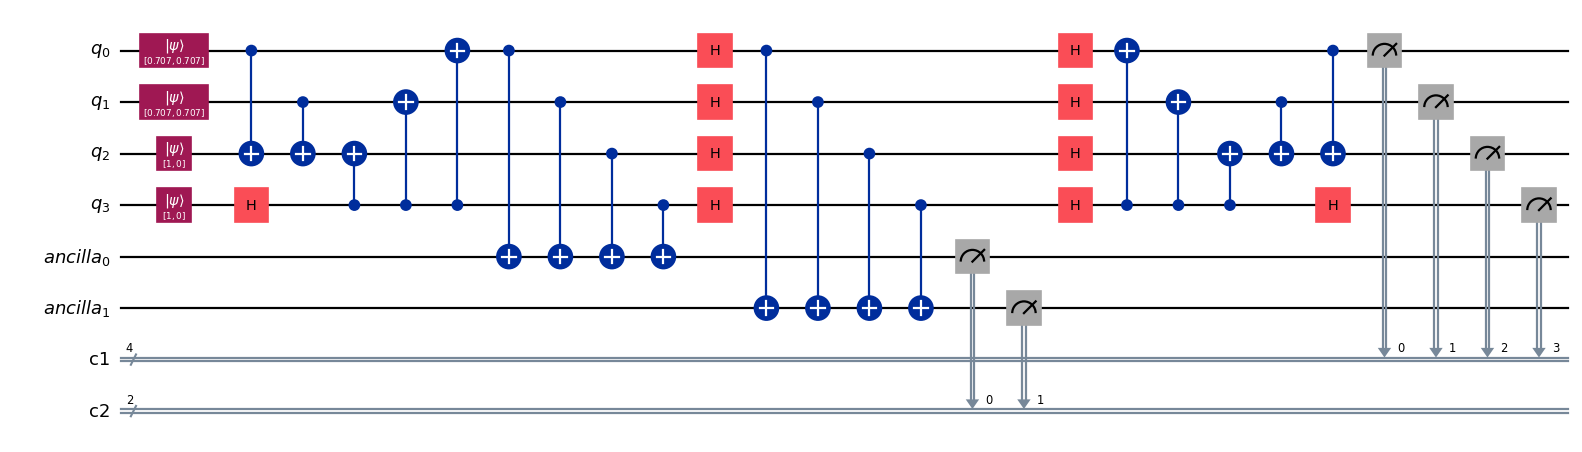

In [3]:
qreg = QuantumRegister(4, 'q')
ancilla = QuantumRegister(2, 'ancilla')
creg1 = ClassicalRegister(4, 'c1')
creg2 = ClassicalRegister(2, 'c2')

qcirc = QuantumCircuit(qreg, ancilla, creg1, creg2)
qcirc.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 0) #prepare state in superposition
qcirc.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 1)
qcirc.initialize([1, 0], 2)
qcirc.initialize([1, 0], 3)

##### encoder
qcirc.h(qreg[3])
qcirc.cx(qreg[0],qreg[2])
qcirc.cx(qreg[1],qreg[2])
qcirc.cx(qreg[3],qreg[2])
qcirc.cx(qreg[3],qreg[1])
qcirc.cx(qreg[3],qreg[0])
#####

#error
qcirc.barrier()
#qcirc.z(0)
#qcirc.x(1)
qcirc.barrier()

for i in range(4):
    qcirc.cx(qreg[i],ancilla[0])

qcirc.barrier()

qcirc.h(qreg)

qcirc.barrier()

for i in range(4):
    qcirc.cx(qreg[i],ancilla[1])

qcirc.barrier()
qcirc.measure(ancilla, creg2)
qcirc.barrier()
qcirc.h(qreg)
qcirc.barrier()

##### decoder 
qcirc.cx(qreg[3],qreg[0])
qcirc.cx(qreg[3],qreg[1])
qcirc.cx(qreg[3],qreg[2])
qcirc.cx(qreg[1],qreg[2])
qcirc.barrier()
qcirc.cx(qreg[0],qreg[2])
qcirc.h(qreg[3])
qcirc.barrier()
#####

qcirc.measure(qreg, creg1)

qcirc.draw("mpl", scale=0.8, fold=-1, plot_barriers=False)

In [4]:
simulator = AerSimulator(method="automatic")
tqc = transpile(qcirc, simulator)
result = simulator.run(tqc, shots=10).result()

{'000000': 2, '000001': 2, '000011': 5, '000010': 1}


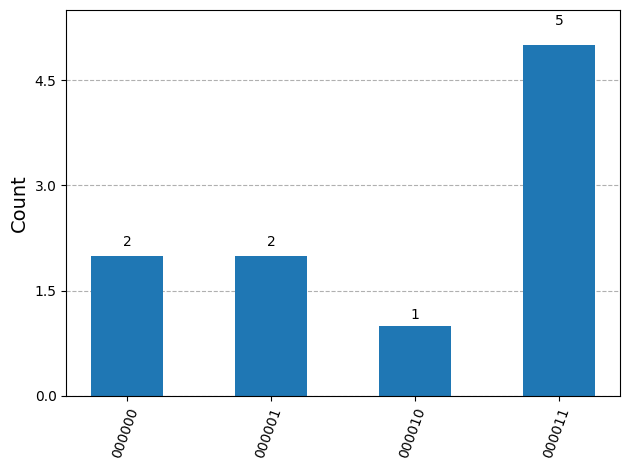

In [5]:
from qiskit.result import marginal_counts
counts = result.get_counts(tqc)

data_counts = marginal_counts(counts)#, indices=range(0,9))

print(data_counts)
plot_histogram(data_counts)

Transpiled code [4,2,2] for gates $R_{x}, R_{y}$, CZ

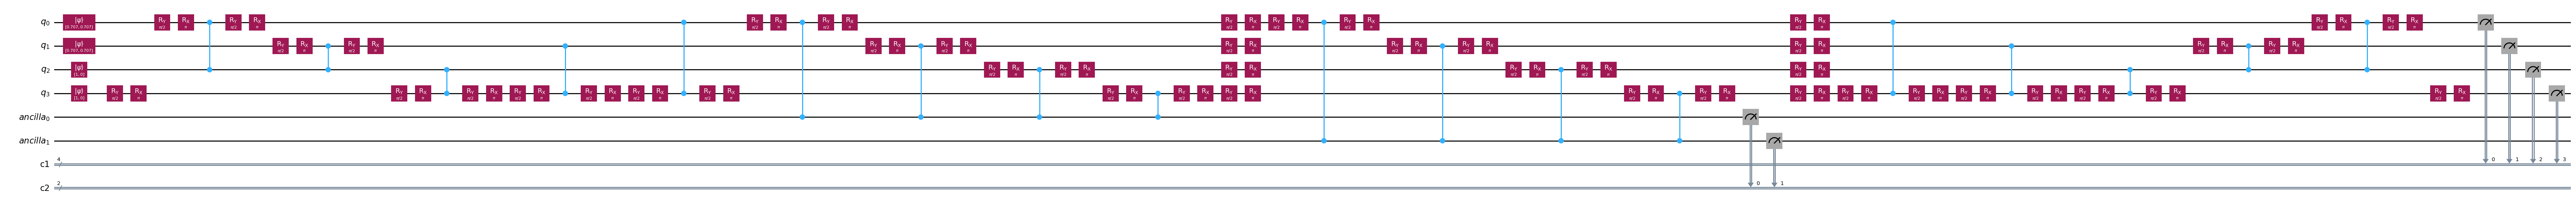

In [29]:
qreg = QuantumRegister(4, 'q')
ancilla = QuantumRegister(2, 'ancilla')
creg1 = ClassicalRegister(4, 'c1')
creg2 = ClassicalRegister(2, 'c2')

qcirc = QuantumCircuit(qreg, ancilla, creg1, creg2)
qcirc.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 0) #prepare state in superposition
qcirc.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 1)
qcirc.initialize([1, 0], 2)
qcirc.initialize([1, 0], 3)

def hadamar(qubit):
    qcirc.ry(pi/2,qubit)
    qcirc.rx(pi,qubit)
    qcirc.barrier()

def cnot(qubit1, qubit2):
    hadamar(qubit1)
    qcirc.cz(qubit1, qubit2)
    hadamar(qubit1)
    qcirc.barrier()

##### encoder
hadamar(qreg[3])

cnot(qreg[0],qreg[2])
cnot(qreg[1],qreg[2])
cnot(qreg[3],qreg[2])
cnot(qreg[3],qreg[1])
cnot(qreg[3],qreg[0])
#####

##### error
qcirc.barrier()
#qcirc.z(0)
#qcirc.x(1)
qcirc.barrier()

for i in range(4):
    cnot(qreg[i],ancilla[0])

qcirc.barrier()
hadamar(qreg)

qcirc.barrier()

for i in range(4):
    cnot(qreg[i],ancilla[1])

qcirc.barrier()
qcirc.measure(ancilla, creg2)
qcirc.barrier()
hadamar(qreg)
qcirc.barrier()

##### decoder 
cnot(qreg[3],qreg[0])
cnot(qreg[3],qreg[1])
cnot(qreg[3],qreg[2])
cnot(qreg[1],qreg[2])
qcirc.barrier()
cnot(qreg[0],qreg[2])
hadamar(qreg[3])
qcirc.barrier()
#####

qcirc.measure(qreg, creg1)

qcirc.draw("mpl", scale=1, fold=-1, plot_barriers=False)

In [84]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer.noise.errors import QuantumError
from qiskit.quantum_info import Operator
from qiskit.circuit.library import RXGate
from qiskit.circuit.library import RYGate

In [85]:
def random_angle_rotation_error(ax,sigma=0.05):
    if ax == 'rx':
        delta = np.random.normal(0, sigma)      
        qc_err = QuantumCircuit(1)
        qc_err.rx(delta, 0)                     
        rx_error = QuantumError([(qc_err, 1.0)])  
        return rx_error
    else:
        delta = np.random.normal(0, sigma)      
        qc_err = QuantumCircuit(1)
        qc_err.ry(delta, 0)
        ry_error = QuantumError([(qc_err, 1.0)])
        return ry_error

In [92]:
rx_error = random_angle_rotation_error('rx', 0.05)
ry_error = random_angle_rotation_error('ry', 0.05)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(rx_error, ['rx'])
noise_model.add_all_qubit_quantum_error(ry_error, ['ry'])

In [93]:
simulator = AerSimulator(method="automatic", noise_model=noise_model)
tqc = transpile(qcirc, simulator)
result = simulator.run(tqc, shots=1000).result()

{'01': 227, '10': 248, '00': 289, '11': 236}


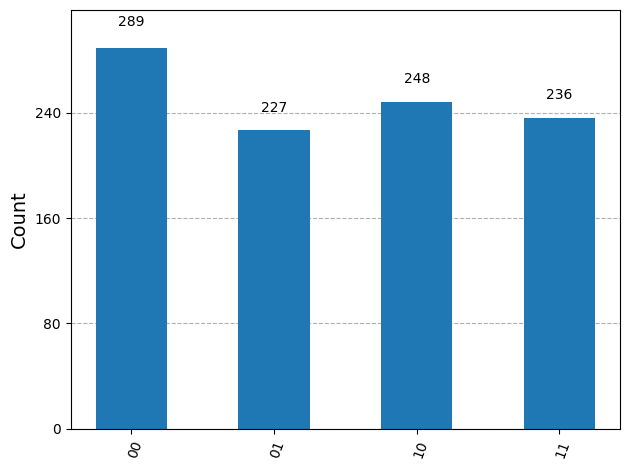

In [94]:
from qiskit.result import marginal_counts
counts = result.get_counts(tqc)

data_counts = marginal_counts(counts, indices=range(0,2))

print(data_counts)
plot_histogram(data_counts)